## Model for outcome in the first 14 days 

In [1]:
# general
import pandas as pd
import numpy as np

from functions import modeling_14d

# plot libarys
import seaborn as sns
import matplotlib.pyplot as plt


# Model preparation
#import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
 

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# Model Metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score, make_scorer # for modelling.py

# for merging the dataframes
import os, glob
import json

# further libarys
#import itertools
from sklearn.tree import export_graphviz
from collections import Counter

%matplotlib inline

In [ ]:
df = pd.read_csv('data/IST_corrected_model.csv',  index_col= [0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17271 entries, 0 to 19434
Columns: 114 entries, HOSPNUM to DEAD
dtypes: float64(16), int64(29), object(69)
memory usage: 15.2+ MB


In [4]:
#convert all 'objects' into 'categories'
df = pd.concat([
        df.select_dtypes([], ['object']),
        df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(df.columns, axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17271 entries, 0 to 19434
Columns: 114 entries, HOSPNUM to DEAD
dtypes: category(69), float64(16), int64(29)
memory usage: 7.2 MB


### Target for 14 days after first stroke

Target for the first model is survival (DDEAD == 'Y') within the first 14 days after the (first) stroke.


In [5]:
df.DDEAD.value_counts()

N    15586
Y     1685
Name: DDEAD, dtype: int64

In [6]:
conditions = [df['DDEAD'].eq('N'), df['DDEAD'].eq('Y')]
choices = [1, 0]

df['ALIVE14'] = np.select(conditions, choices, default=np.nan)

In [7]:
df.ALIVE14.value_counts()

1.0    15586
0.0     1685
Name: ALIVE14, dtype: int64

In [8]:
# Select features
features = ['SEX', 'AGE', 'RSBP', 'STYPE', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RDEF8', 
                'DASP14', 'DLH14', 'DLM14', 'RASP3', 'RHEP24', 'RDELAY']
X = df[features]

# Select target
y = df.ALIVE14

In [9]:
print(sorted(Counter(y).items()))

[(0.0, 1685), (1.0, 15586)]


In [10]:
print(f'Patients deceased: {round((df.ALIVE14.value_counts()[0] / df.shape[0] * 100),1)} %')
print(f'Patients alive: {round((df.ALIVE14.value_counts()[1] / df.shape[0] * 100),1)} %')

Patients deceased: 9.8 %
Patients alive: 90.2 %


We have an imbalanced dataset - with a distribution of 90% alive and 10% deceased patients after an ischaemic stroke. Below 

### Undersampling 

Combined over- and undersampling did not result in better results, neither did changing the 'sampling_strategy'. Thus, we continued with undersampling of the majority class.

In [11]:
# summarize class distribution
#print(Counter(y))
# define oversampling strategy
#over = RandomOverSampler(sampling_strategy=0.25)
# fit and apply the transform
#X, y = over.fit_resample(X, y)
# summarize class distribution
#print(Counter(y))
# define undersampling strategy
#under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
#X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

Counter({1.0: 15586, 0.0: 1685})


In [12]:
# Split the data in test and training set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [14]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

In [15]:
print(sorted(Counter(y_under).items()))

[(0.0, 1685), (1.0, 1685)]


In [16]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

#### Helper functions

In [17]:
def pred_eval_plot_model(X_train, X_test, y_train, y_test, clf, cv=None):
    """Train a single model and print evaluation metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        clf (sklearn.base.BaseEstimator): Estimator to train and use
        cv (int, None): Number of cross-validations, default=None
    
    Returns:
        model (sklearn.base.BaseEstimator): The trained model
    """
    model = clf.fit(X_train, y_train)

    if cv:
        cv = cross_validate(m_rf, X_train_trans, y_train, cv=5, verbose=5)
        print(f"Best cross-validated score: {cv['test_score'].mean()}")
    
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(f"--- MODEL PARAMETERS {'-'*10}")
    print(json.dumps(model.get_params(), indent=4))
    print(f"--- F1-Score {'-'*10}")
    print(f1_score(y_test, y_pred))
    print(f"--- CLASSIFICATION REPORT {'-'*10}")
    print(classification_report(y_test,y_pred))
    print(f"--- CONFUSION MATRIX {'-'*10}")
    print(confusion_matrix(y_test,y_pred))
    plot_confusion_matrix(model, X_test, y_test, display_labels=["deceased", "alive"])
    return model

def _pred_eval_plot_grid(X_train, X_test, y_train, y_test, gs):
    """Helper function to perform a grid search and calculate performance metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        gs (BaseSearchCV): SearchCV to train and use
    
    Returns:
        model (BaseSearchCV): The trained grid search
    """

    gs = gs.fit(X_train, y_train)
    
    # Testing predictions (to determine performance)
    y_pred = gs.best_estimator_.predict(X_test)
    
    print(f"--- GRID SEARCH RESULTS {'-'*10}")
    print(f"Best model: {gs.best_params_}")
    #print(f"Best cross-validated F1-Score: {gs.f1_scorer}")
    print(f"--- CLASSIFICATION REPORT {'-'*10}")
    print(classification_report(y_test,y_pred))
    print(f"--- CONFUSION MATRIX {'-'*10}")
    print(confusion_matrix(y_test,y_pred))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, y_test, display_labels=["deceased", "alive"])
    return gs
    

def run_rand_grid_search(X_train, X_test, y_train, y_test, clf, params_grid, n_iter=10, cv=5):
    """Perform a randomized grid search and calculate performance metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        clf (sklearn.base.BaseEstimator): Estimator to train and use
        params_grid (dict): Dictionary defining the parameters for the grid search
        n_iter (int): Number of grid search combinations to run
        cv (int, None): Number of cross-validations, default=None
        
    Returns:
        model (BaseSearchCV): The trained grid search
    """
    f1_scorer = make_scorer(f1_score, pos_label= 1)
    gs = RandomizedSearchCV(clf, params_grid, n_iter=n_iter, cv=cv, random_state=24, verbose=5, scoring=f1_scorer)
    return _pred_eval_plot_grid(X_train, X_test, y_train, y_test, gs)
    
def run_grid_search(X_train, X_test, y_train, y_test, clf, params_grid, cv=5):
    """Perform a grid search and calculate performance metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        clf (sklearn.base.BaseEstimator): Estimator to train and use
        params_grid (dict): Dictionary defining the parameters for the grid search
        cv (int, None): Number of cross-validations, default=None
        
    Returns:
        model (BaseSearchCV): The trained grid search
    """
    gs = GridSearchCV(clf, params_grid, cv=cv, verbose=5)
    return _pred_eval_plot_grid(X_train, X_test, y_train, y_test, gs)
    

### Preparation of Data Scaling and Category Encoding
Some models need scaling of numerical features and encoding of categorical features. The sklearn preprocessors are instantiated here and used where necessary in the data transformation step of each model.

In [18]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include="category")

### Choosing a metric

We need to define a suitable metric for evaluating model performance. We saw earlier, that we have an imbalanced dataset. Even though we balanced this (by undersampling) we will use F1 Score as metric for model selection.

For our final model selection and parameter tuning, we want to be sure that we predict the survival only in case the patient really was alive after 14 days. Hence, we use precision as final model metric.

### Logistic Regression with Standard Scaler

In [25]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": null,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- F1-Score ----------
0.6415094339622641
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.66      0.63      0.64       521
         1.0       0.62      0.66      0.64       490

    accuracy                           0.64      1011
   macro avg       0.64      0.64      0.64      1011
weighted avg       0.64      0.64      0.64      1011

--- CONFUSION MATRIX ----------
[[327 194]
 [167 323]]


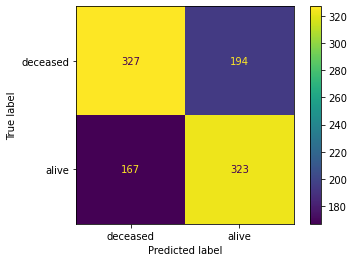

In [26]:
logreg_ss = LogisticRegression(max_iter=400)
m_logreg_ss = pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg_ss)

In [22]:
#mlflow.end_run()

The simple logistic model with standard scaling of the numerical features achieves an F1 Score of 64% and a precision of 62%, both for living patients.

In [30]:
# Classification report
y_probs = m_logreg_ss.predict_proba(X_test_trans)[:, 1]

y_pred = y_probs > 0.9
print(f"--- CLASSIFICATION REPORT {'-'*10}")
print(classification_report(y_test,y_pred))
print(f"--- CONFUSION MATRIX {'-'*10}")
print(confusion_matrix(y_test,y_pred))

--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.68       521
         1.0       1.00      0.02      0.04       490

    accuracy                           0.52      1011
   macro avg       0.76      0.51      0.36      1011
weighted avg       0.75      0.52      0.37      1011

--- CONFUSION MATRIX ----------
[[521   0]
 [481   9]]


Adjusting the threshold to 0.9, the precision for living patients can be increased to 100%, reducing the F1 Score to 4%.

### Logistic Regression with MinMax Scaling

In [31]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": null,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- F1-Score ----------
0.6422200198216056
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.66      0.63      0.64       521
         1.0       0.62      0.66      0.64       490

    accuracy                           0.64      1011
   macro avg       0.64      0.64      0.64      1011
weighted avg       0.64      0.64      0.64      1011

--- CONFUSION MATRIX ----------
[[326 195]
 [166 324]]


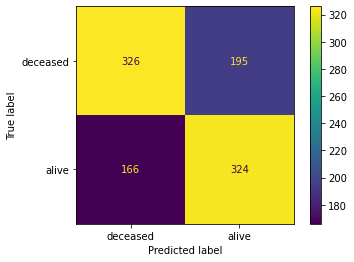

In [32]:
# Calculate the LogisticRegression
logreg = LogisticRegression(max_iter=400)
m_logreg_mm = pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg)

In [26]:
#with mlflow.start_run() as run:
    #logreg_mm.fit(X_train_trans, y_train)

The simple logistic model with MinMax scaling of the numerical features achieves an F1 Score of 64% and a precision of 62%, both for living patients.

In [35]:
# Classification report
y_probs = m_logreg_mm.predict_proba(X_test_trans)[:, 1]

y_pred = y_probs > 0.9
print(f"--- CLASSIFICATION REPORT {'-'*10}")
print(classification_report(y_test,y_pred))
print(f"--- CONFUSION MATRIX {'-'*10}")
print(confusion_matrix(y_test,y_pred))

--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.68       521
         1.0       1.00      0.02      0.03       490

    accuracy                           0.52      1011
   macro avg       0.76      0.51      0.36      1011
weighted avg       0.75      0.52      0.37      1011

--- CONFUSION MATRIX ----------
[[521   0]
 [482   8]]


Adjusting the threshold to 0.9, the precision for living patients can be increased to 100%, reducing the F1 Score to 4%.

Overall, there is no difference between using the Standard Scaler and the MinMax Scaler.

In [28]:
### Logistic Regression with Randomized Grid Search

In [ ]:
params_grid = {
    "penalty": ["elasticnet"],
    "C": np.logspace(-3, 3, 7),
    "max_iter": [200],
    "l1_ratio": np.arange(0, 1, 0.25),
    "solver": ["saga"],
}
rs_logreg = run_rand_grid_search(X_train_trans, X_test_trans, y_train, y_test, logreg, params_grid, cv=3, n_iter=20)

The best model with randomized search is achieved with {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 200, 'l1_ratio': 0.75, 'C': 0.1} with a cross-validated F1 Score of 67% for living patients.

The precision of the best model is 61%. Therefore, we could not find a parameter combination that improves precision.

## KNN

### Data Transformation

KNN compares observations based on a similarity measure. Therefore, we need to scale numerical features and use one-hot-encoding for our categorical features. Using one-hot encoding creates a sparse matrix and reduces KNN efficiency. 

In [19]:
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()

# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, make_column_selector(dtype_include="category")),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

### Simple KNN

We will use the manhattan distance for similarity as our data is sparse.

In [20]:
# Define Classifier
knn = KNeighborsClassifier(p=1, n_jobs=-1)

--- MODEL PARAMETERS ----------
{
    "algorithm": "auto",
    "leaf_size": 30,
    "metric": "minkowski",
    "metric_params": null,
    "n_jobs": -1,
    "n_neighbors": 5,
    "p": 1,
    "weights": "uniform"
}
--- F1-Score ----------
0.6199794026776518
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65       521
         1.0       0.63      0.61      0.62       490

    accuracy                           0.64      1011
   macro avg       0.63      0.63      0.63      1011
weighted avg       0.63      0.64      0.63      1011

--- CONFUSION MATRIX ----------
[[341 180]
 [189 301]]


KNeighborsClassifier(n_jobs=-1, p=1)

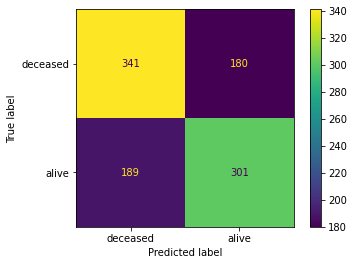

In [21]:
pred_eval_plot_model(X_train_trans , X_test_trans, y_train, y_test, knn)

F1 Score: 62% and precision is 63%

In [30]:
params_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
gs_knn = run_grid_search(X_train_trans, X_test_trans, y_train, y_test, knn, params_grid, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   3.5s
[CV 2/3] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV 3/3] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV 1/3] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 2/3] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 3/3] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 1/3] END metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV 2/3] END metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV 3/3] END metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV 1/3] END metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV 2/3] END metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV 3/3] END metric=euclidean, n

KeyboardInterrupt: 

Best model: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

F1-Score 70

Precision 80

## Decision Tree

For Decision Trees numerical data doesn't need to be scaled. Categorical data needs to be encoded. As One-Hot-Encoding leads to sparse data and decreases the performance of decision trees, we encode the categories numerically.

In [22]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ["SEX", "STYPE"]:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

### Simple Decision Tree

In [23]:
# Define Classifier
dtree = DecisionTreeClassifier(random_state=42)

--- MODEL PARAMETERS ----------
{
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": null,
    "max_leaf_nodes": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "random_state": 42,
    "splitter": "best"
}
--- F1-Score ----------
0.5769230769230769
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.61      0.66      0.64       521
         1.0       0.61      0.55      0.58       490

    accuracy                           0.61      1011
   macro avg       0.61      0.61      0.61      1011
weighted avg       0.61      0.61      0.61      1011

--- CONFUSION MATRIX ----------
[[345 176]
 [220 270]]


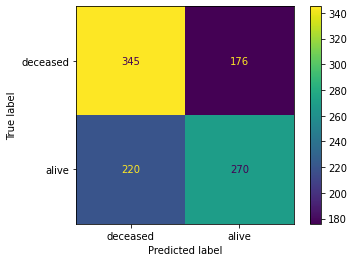

In [24]:
m_dtree = pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, dtree)

F1 SCORE 58

Precision 61